# Author: Wen Cui, Vrindavan Harrison

# 1. Read input and extract features
We process the text by lowercase and removing punctuation and converted to feature matrix with occurancy in the text.
And then we apply tfidf transform.

# 1.1 Our input

In [1]:
import pandas as pd
df = pd.read_csv('./train.csv', encoding='utf-8')
df.head()

,handle,tweet
0,HillaryClinton,The question in this election: Who can put the...
1,HillaryClinton,"Last night, Donald Trump said not paying taxes..."
2,HillaryClinton,"If we stand together, there's nothing we can't..."
3,HillaryClinton,Both candidates were asked about how they'd co...
4,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...


# 1.2 Feature matrix with count of words
Convert text into feature matrix with each row is a line, and each row if the count of the words in the message
<br> 1=HillaryClinton, 0=realDonaldTrump

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn.model_selection import KFold


def feature_matrix(file_name, vectorizer=None):
    df = pd.read_csv(file_name, encoding='utf-8')
    texts = []
    y = []
    for i in range(0, len(df.index)):
        if df.ix[i, 'handle'] == 'HillaryClinton':
            y.append(1)
        elif df.ix[i, 'handle'] == 'realDonaldTrump':     
            y.append(0)
        texts.append(df.ix[i, 'tweet'])
    X, vec = extract_feature(texts, vectorizer)
    y = np.array(y).T
    print("X matrix shape is {0}".format(X.shape))
    print("y vector shape is {0}".format(y.shape))
    print("HillaryClinton's length is {0} and realDonaldTrump's length is {1}".format(sum(y), len(y)-sum(y)))
    return X, y, vec
                      

def extract_feature(texts, vectorizer=None):
    # TODO: regex for remove only punct
    if vectorizer is None:
        vectorizer = CountVectorizer(decode_error='ignore',stop_words='english', min_df=2)
        X = vectorizer.fit_transform(texts).toarray()
    else:
        X = vectorizer.transform(texts).toarray()
        
    return X, vectorizer

# 1.3 Tfidf transform
Tfidf with l2 normalization

In [7]:
def tfidf_transform(counts):
    transformer = TfidfTransformer(norm='l2',smooth_idf=False)
    tfidf = transformer.fit_transform(counts).toarray()
    return tfidf

# 1.4 All together
Now we can process training dataset. We can see the data in the training set are very inbalance since there are only $13.9\%$ of the data is labeled as spam.

In [8]:
def process_text(filename, vector=None):
    X, y, vec= feature_matrix(filename, vector) 
    X = tfidf_transform(X)
    return X, y, vec 

print("in train.csv data:")  
X, y, vectorizer = process_text('./train.csv')

in train.csv data:
X matrix shape is (4743, 3680)
y vector shape is (4743,)
HillaryClinton's length is 2362 and realDonaldTrump's length is 2381


Let's look at the feature matrix and label vector we produced above, it's sparse and contains lots of 0

In [9]:
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3670,3671,3672,3673,3674,3675,3676,3677,3678,3679
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df = pd.DataFrame(y)
df.head()

,0
0,1
1,1
2,1
3,1
4,0


# 2. Logistic Regression with regularization

## 2.1 Sigmoid function
We firstly implement sigmoid function which is the activation function that converts continous input into values between 0 and 1. Then we can use this value as probability. Then if we apply with a threadhold, we can have a classification labels as used in later section.


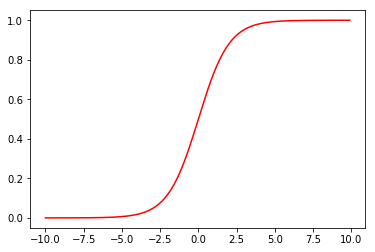

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

nums = np.arange(-10, 10, step=0.1)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nums, sigmoid(nums), 'r')

## 2.2 Loss funtion with $\lambda ||w||^2$ regularization
Next, we implement the loss function for logistic regression with regularization. The loss function can be calculated by summing up relative entropy over the batch,
\begin{equation*}
LR = \sum_{n}\{-yln\sigma (w X)-(1-y)ln(1-\sigma (wX))\} + \frac{\lambda}{2}||w||^2 \
\end{equation*}

In [12]:
from numpy import linalg as LA


def cross_entropy(X, w, y, lmda):
    total_loss = 0
    n = X.shape[0]
    predictions = np.zeros(y.shape)

    for i in range(n):
        yhat = sigmoid(np.dot(X[i,:], w))
        if y[i] == 0.0:
            loss = -(1 - y[i]) * np.log(1 -yhat) 
        elif y[i] == 1.0:
            loss = - y[i] * np.log(yhat) 
        else:
            loss = -(1 -y[i]) * np.log(1 - yhat) - y[i] * np.log(yhat) 

        total_loss += np.sum(loss) + (lmda/2) * np.sum(np.dot(w[1:].T, w[1:]))
        predictions[i] = yhat

    grad = np.dot(X.T, predictions - y)

    return total_loss, grad

## 2.3 Batch gradient descent with $\lambda ||w||^2$ regularization
batch gradient descent logistic regression with regularizer
$\lambda ||w||^2$ and learning rate $\eta \times t^{−\alpha}$ where $\eta$ is a constant, $t$ is the iteration number and $\alpha = .9$.
The update function with regularizer can be defined as
\begin{cases}
w_{t+1} = w_{t} - \nabla_{w_0}loss &, w_0 \\
w_{t+1} = w_{t}(1-\eta_t \lambda) - \eta_t \sum_{n}(\sigma(w_t X_n) - y_n)X_n) &, w_i  (i \neq 0)\\
\end{cases}
<br> We also handle the bias term by concatenating 1 on the first row of $X$, and get new updates seperately as shown above.

In [13]:

def cal_error(X, y, w):
    return y - sigmoid(np.matmul(X, w)) 

def gradient_decent(_X, y, eta=None, lam=None, num_iterations=1000):
    # add one extra dimension for the bias term
    X = np.concatenate([np.ones(shape=(_X.shape[0],1)), _X], axis=1)

    # initialize weight vector
#     w = 0.001 * np.ones(shape=(X.shape[1]))
    w = 0.01 * np.random.rand(X.shape[1])
    loss = None

    for t in range(1, num_iterations+1):
        # calculate cross entropy loss
        loss, grad = cross_entropy(X, w, y, lam)

        if eta is None:
            learn_rate = 0.01
        else:
            alpha = 0.9
            learn_rate = eta * (float(t) ** -alpha)

        w1 = w[1:] * (1 - learn_rate * lam) - (learn_rate * grad[1:])
        bias = w[0] - (learn_rate * grad[0])
        w_new = np.concatenate([[bias], w1])
        loss_new, _ = cross_entropy(X, w_new, y, lam)
        loss_old, _ = cross_entropy(X, w, y, lam)
        if abs(loss_old - loss_new) <= 1:
            w = w_new
            break
        w = w_new

        # print the current training  loss
        if t % 50 == 0:
            #print("step {} loss:".format(t), loss)
            pass
        
    return w, loss

# 2.4 Regression model with $\lambda w$ regularization
Now we have a different regression loss
\begin{equation*}
LR' = \sum_{n}\{-yln\sigma (w X)-(1-y)ln(1-\sigma (wX))\} + \lambda w
\end{equation*}
And different updates,
\begin{cases}
w_{t+1} = w_{t} - \nabla_{w_0}loss &, w_0 \\
w_{t+1} = w_{t} - \eta_t \sum_{n}((\sigma(w_t X_n) - y_n)X_n) - \vec{\lambda}) &, w_i  (i \neq 0)\\
\end{cases}
<br> We also implement without regularized on bias term.

In [17]:
def cross_entropy_1(X, w, y, lmda):
    total_loss = 0
    n = X.shape[0]
    predictions = np.zeros(y.shape)

    for i in range(n):
        yhat = sigmoid(np.dot(X[i,:], w))
        if y[i] == 0.0:
            loss = -(1 - y[i]) * np.log(1 -yhat) 
        elif y[i] == 1.0:
            loss = - y[i] * np.log(yhat) 
        else:
            loss = -(1 -y[i]) * np.log(1 - yhat) - y[i] * np.log(yhat) 

        total_loss += np.sum(loss) + lmda * np.sum(w[1:])
        predictions[i] = yhat

    grad = np.dot(X.T, predictions - y)

    return total_loss, grad

def gradient_decent_1(_X, y, eta=None, lam=None, num_iterations=1000):
    # add one extra dimension for the bias term
    X = np.concatenate([np.ones(shape=(_X.shape[0],1)), _X], axis=1)

    # initialize weight vector
#     w = 0.001 * np.ones(shape=(X.shape[1]))
    w = 0.01 * np.random.rand(X.shape[1])
    loss = None

    for t in range(1, num_iterations+1):
        # calculate cross entropy loss
        loss, grad = cross_entropy_1(X, w, y, lam)

        if eta is None:
            learn_rate = 0.01
        else:
            alpha = 0.9
            learn_rate = eta * (float(t) ** -alpha)

        w1 = w[1:] - learn_rate * (grad[1:] - lam * (np.ones(w.shape - 1)[1:]))
        bias = w[0] - (learn_rate * grad[0])
        w_new = np.concatenate([[bias], w1])
        loss_new, _ = cross_entropy_1(X, w_new, y, lam)
        loss_old, _ = cross_entropy_1(X, w, y, lam)
#         if abs(loss_old - loss_new) <= 1:
#             w = w_new
#             break
        w = w_new

        # print the current training  loss
        if t % 50 == 0:
            #print("step {} loss:".format(t), loss)
            pass
        
    return w, loss   

# 3. 10-fold crossvalidation
Choose λ with 10-fold cross validation based on the classification accuracy. Report your results as in solutions to Hw 1: cross validation curve (with error bars if you can) plus table of results with best choices/results bolded.

In [22]:
from sklearn import model_selection

def predict(_X, w):
    # add dummy bias term
    X = np.concatenate([np.ones(shape=(_X.shape[0],1)), _X], axis=1)

    n = X.shape[0]
    predictions = np.zeros(X.shape[0])

    for i in range(n):
        yhat = sigmoid(np.dot(X[i,:], w))
        predictions[i] = 1 if yhat > 0.5 else 0

    return predictions

def predict_test(_X, w):
    # add dummy bias term
    X = np.concatenate([np.ones(shape=(_X.shape[0],1)), _X], axis=1)

    n = X.shape[0]
    predictions = np.zeros(X.shape[0])

    for i in range(n):
        predictions[i] = sigmoid(np.dot(X[i,:], w))

    return predictions



def get_accuracy(preds, target):      
    accuracy = (preds == target).sum().astype(float) / len(preds)
    return accuracy


def cross_validation(lmda, X, y, iteration, eta, l2=True):
    errors_train = []
    errors = []

    kf = model_selection.KFold(n_splits=2, shuffle=True, random_state=None)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w, cost = gradient_decent(X_train, y_train, eta, lmda, iteration)
        # Accuracy on validation
        predictions = predict(X_val, w)
        acc = get_accuracy(predictions, y_val)
        errors.append(acc) 
        # Accuracy on training
        pred_train = predict(X_train, w)
        acc_train = get_accuracy(pred_train, y_train)
        errors_train.append(acc_train)
    avg_err = np.sum(errors)/len(errors)
    avg_err_train = np.sum(errors_train)/len(errors_train)
    return avg_err, errors, avg_err_train

# 4. Test model

# 4.1 Accuracy on different models with $\lambda w^2$ regularization
We manually set iteration as 50, although from our observation, some optimal weights are not achieved. The larger the iteration is , the better the results are. But it takes such a long time, so we take a relative small number of iteration with a relative larger learning rate $\eta$.

/Users/Daisy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


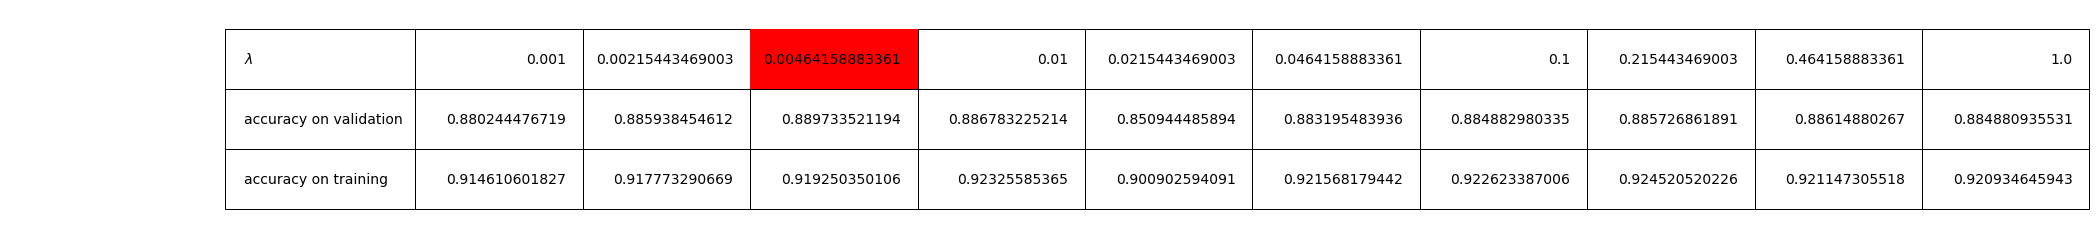

In [19]:
errs = []
eta = 0.1
iteration = 50
accuracies = []
accuracies_train = []
lmds = np.logspace(-3, 0, 10)
for idx, ld in enumerate(lmds):
    acc, err, acc_train = cross_validation(ld, X, y, iteration, eta)
    errs.append(err)
    accuracies.append(acc)
    accuracies_train.append(acc_train)

# Plot the results in a table
fig, ax = plt.subplots()
# col_labels = ['%f' % l for l in lmds]
row_label = ['$\lambda$','accuracy on validation', 'accuracy on training']
table = ax.table(cellText=[lmds, accuracies, accuracies_train],
          rowLabels=row_label,
          loc='center')
best_lmd = table.get_celld()[(0,np.argmax(accuracies))]
best_lmd.set_color('r')
ax.axis('off')
table.set_fontsize(30)
table.scale(5,5)  

# 4.2 Plot cross validation curve with error bar

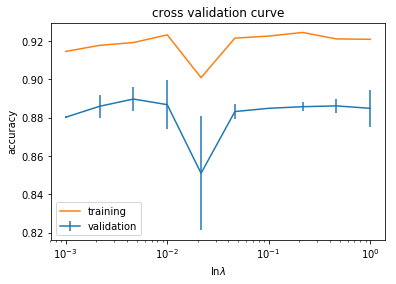

In [20]:
errs_min = np.amin(errs, axis=1)
errs_max = np.amax(errs, axis=1)
y_err = []
for i in range(len(accuracies)):
    y_err.append((errs_max[i] - accuracies[i], accuracies[i] - errs_min[i]))
y_err = np.array(y_err).T
fig, ax = plt.subplots()
# ax.plot(lmds, accuracies)
ax.errorbar(lmds, accuracies, y_err)
ax.plot(lmds, accuracies_train)
ax.set_xscale('log')
plt.ylabel('accuracy')
plt.xlabel('ln$\lambda$')
plt.legend(['training', 'validation'])
plt.title('cross validation curve')

# 4.3 Prediction on test data
Get the best lambda value and retrain on all training data.
<br> Output result

In [26]:
from collections import OrderedDict

best_lmda = lmds[np.argmax(accuracies)]
best_w,_ = gradient_decent(X, y, eta, best_lmda, iteration)

print('in test.csv data: ')
X_test, y_test, __ = process_text('./test.csv', vectorizer)

# evaluate our model on test data
predictions_HC = predict_test(X_test, best_w)
predictions_DT = np.ones(len(predictions_HC)) - predictions_HC

# write result
data = OrderedDict()
data['id'] = [i for i in range(0, len(predictions))]
data['realDonaldTrump'] = predictions_DT
data['HillaryClinton'] = predictions_HC
df = pd.DataFrame(data=data)
df.to_csv('./LG_result.csv', index=False)

/Users/Daisy/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


in test.csv data: 
X matrix shape is (1701, 3680)
y vector shape is (0,)
HillaryClinton's length is 0 and realDonaldTrump's length is 0


/Users/Daisy/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1037: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0
